Overview

The goal of this competition is to predict the age of abalones (i.e. aproximately the number of rings + 1.5) from various physical measurements.

In this particular case, I used autogluon to create an weighted ensemble from CatBoost, LGBM and pytorch NN models.

# Import libraries

In [1]:
!mkdir -p /tmp/pip/cache/

In [2]:
!pip3 install -q autogluon

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.8.2 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
aiobotocore 2.12.2 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.29.165 which is incompatible.
albumentations 1.4.0 requires scikit-image>=0.21.0, but you have scikit-image 0.20.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.5 which is incomp

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn import metrics

# Load data

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# EDA

In [5]:
train_df.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [6]:
train_df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [7]:
train_df['Sex'].value_counts()

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

In [8]:
# onehotencode sex

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'Sex' column
sex_encoded = encoder.fit_transform(train_df[['Sex']])
sex_encoded_test = encoder.fit_transform(test_df[['Sex']])

# Convert the encoded values into a DataFrame
sex_encoded_df = pd.DataFrame(sex_encoded.toarray(), columns=encoder.get_feature_names_out(['Sex']))
sex_encoded_test = pd.DataFrame(sex_encoded_test.toarray(), columns=encoder.get_feature_names_out(['Sex']))

# Concatenate the original DataFrame with the encoded DataFrame
train_df_encoded = pd.concat([train_df, sex_encoded_df], axis=1)
test_df_encoded = pd.concat([test_df, sex_encoded_test], axis=1)

# Drop the original 'Sex' column
train_df_encoded.drop(columns=['Sex'], inplace=True)
test_df_encoded.drop(columns=['Sex'], inplace=True)

print(train_df_encoded.head())
print(test_df_encoded.head())

   id  Length  Diameter  Height  Whole weight  Whole weight.1  Whole weight.2  \
0   0   0.550     0.430   0.150        0.7715          0.3285          0.1465   
1   1   0.630     0.490   0.145        1.1300          0.4580          0.2765   
2   2   0.160     0.110   0.025        0.0210          0.0055          0.0030   
3   3   0.595     0.475   0.150        0.9145          0.3755          0.2055   
4   4   0.555     0.425   0.130        0.7820          0.3695          0.1600   

   Shell weight  Rings  Sex_F  Sex_I  Sex_M  
0        0.2400     11    1.0    0.0    0.0  
1        0.3200     11    1.0    0.0    0.0  
2        0.0050      6    0.0    1.0    0.0  
3        0.2500     10    0.0    0.0    1.0  
4        0.1975      9    0.0    1.0    0.0  
      id  Length  Diameter  Height  Whole weight  Whole weight.1  \
0  90615   0.645     0.475   0.155        1.2380          0.6185   
1  90616   0.580     0.460   0.160        0.9830          0.4785   
2  90617   0.560     0.420   0.14

<Axes: >

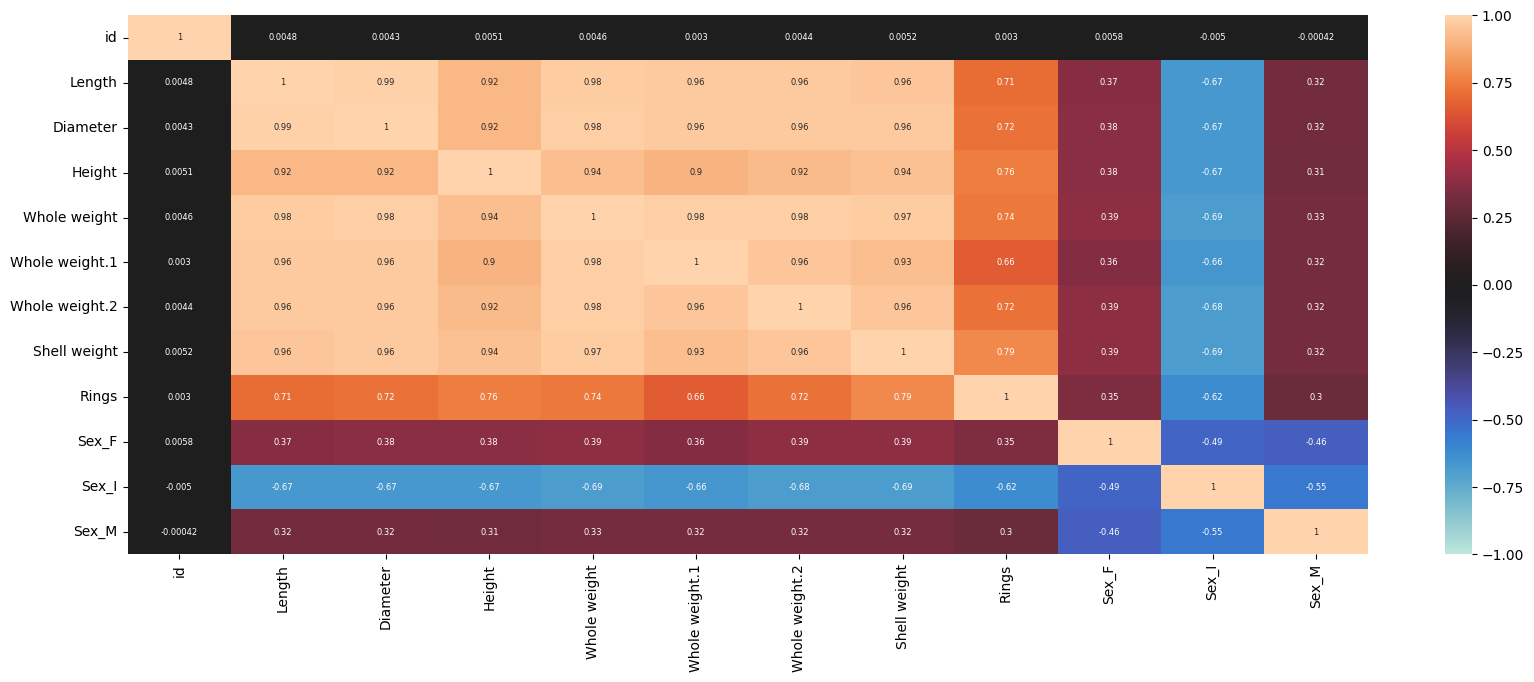

In [9]:
plt.figure(figsize=(20, 7))
sns.heatmap(train_df_encoded.loc[:].corr(method='spearman'),vmin=-1,vmax=1,center=0,annot=True, annot_kws={"fontsize": 6})

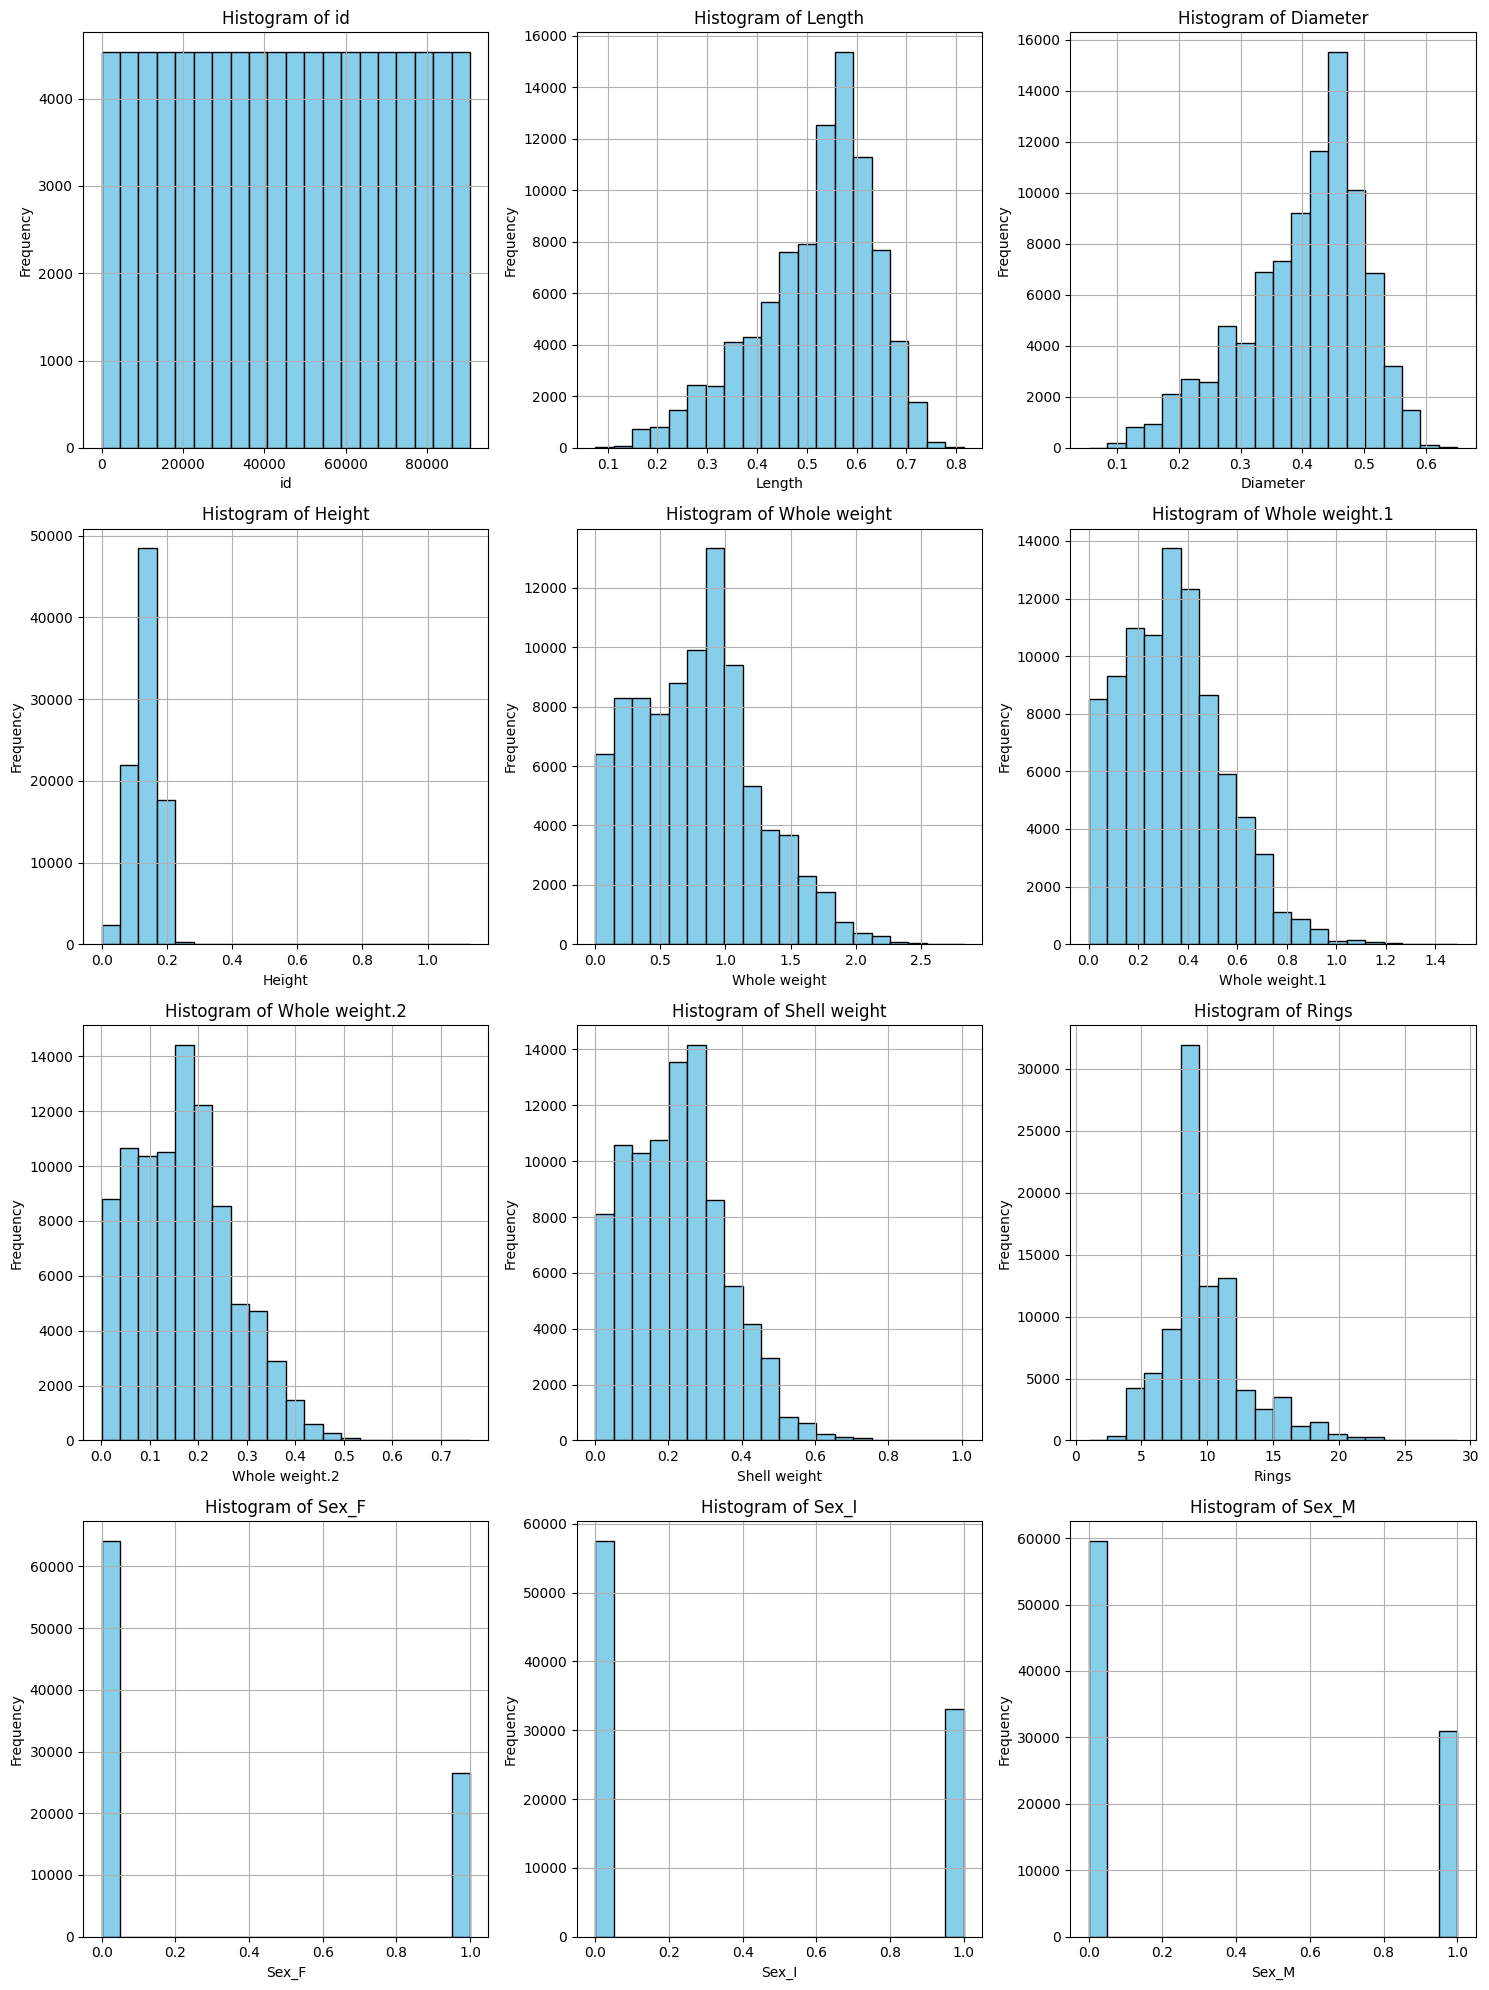

In [10]:
# Calculate the number of rows needed based on the number of columns
num_cols = len(train_df_encoded.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust the number 3 to change the number of histograms per row

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and plot a histogram
for i, column in enumerate(train_df_encoded.columns):
    ax = axes[i]
    ax.hist(train_df_encoded[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')
    ax.grid(True)

# Hide any unused subplots
for j in range(i+1, num_rows*3):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Training

In [11]:
train_df_splits = train_df_encoded.drop(['id'], axis=1)

In [12]:
#split data into train and validation
train, valid = train_test_split(train_df_splits, test_size=0.2, random_state=42)

In [13]:
train = TabularDataset(train)
valid = TabularDataset(valid)
test_data = TabularDataset(test_df_encoded)

In [14]:
from autogluon.core.metrics import make_scorer
ag_rmsle_scorer = make_scorer(name='rmsle',
                                 score_func=metrics.root_mean_squared_log_error,
                                 optimum=0,
                                 greater_is_better=False)

In [15]:
predictor = TabularPredictor(label='Rings', 
                             problem_type='regression',
                            eval_metric = ag_rmsle_scorer,
                            path='predictor')

In [16]:
predictor = TabularPredictor(label='Rings', 
                             problem_type='regression',
                            eval_metric = ag_rmsle_scorer,
                            path='predictor')

In [17]:
%%time
predictor.fit(
    train,
    tuning_data=valid,
    save_space=True,
    presets="optimize_for_deployment",
    use_bag_holdout=True,
    hyperparameters='multimodal'
)

Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ...
AutoGluon will save models to "predictor"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       30.06 GB / 31.36 GB (95.8%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Train Data Rows:    72492
Train Data Columns: 10
Tuning Data Rows:    18123
Tuning Data Columns: 10
Label Column:       Rings
Problem Type:       regression
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:189: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

[1000]	valid_set's l2: 3.43339	valid_set's rmsle: -0.153715


	-0.1511	 = Validation score   (-rmsle)
	8.71s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's l2: 3.57816	valid_set's rmsle: -0.156654
[2000]	valid_set's l2: 3.53104	valid_set's rmsle: -0.155739
[3000]	valid_set's l2: 3.51369	valid_set's rmsle: -0.155085
[4000]	valid_set's l2: 3.5092	valid_set's rmsle: -0.154893


	-0.1526	 = Validation score   (-rmsle)
	29.04s	 = Training   runtime
	1.92s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1509	 = Validation score   (-rmsle)
	71.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1518	 = Validation score   (-rmsle)
	2.85s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1552	 = Validation score   (-rmsle)
	98.73s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: VowpalWabbit ...
		Currently, we only support vowpalwabbit version >=9.0 and <9.9. Found vowpalwabbit version: 9.9.0
Detailed Traceback:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1817, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/trainer/abstract_trainer.py", li

CPU times: user 6min 44s, sys: 4.88 s, total: 6min 49s
Wall time: 3min 40s


In [18]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.150143,rmsle,0.455845,179.518251,0.001209,0.731622,2,True,4
1,CatBoost,-0.150862,rmsle,0.037630,71.351473,0.037630,71.351473,1,True,2
2,LightGBM,-0.151135,rmsle,0.377052,8.706979,0.377052,8.706979,1,True,1
3,NeuralNetTorch,-0.155154,rmsle,0.039955,98.728176,0.039955,98.728176,1,True,3


In [19]:
predictor.model_best

'WeightedEnsemble_L2'

# Inference

In [20]:
predictions = predictor.predict(test_data)

In [21]:
predictions

0         9.598310
1         9.712071
2         9.959468
3        10.469245
4         7.581785
           ...    
60406     6.406581
60407     9.474079
60408    12.961798
60409    13.345982
60410     8.517853
Name: Rings, Length: 60411, dtype: float32

In [22]:
#make sure all predictions are within the actual dataset limits
np.clip(predictions, a_min = 1.0, a_max = 29)

0         9.598310
1         9.712071
2         9.959468
3        10.469245
4         7.581785
           ...    
60406     6.406581
60407     9.474079
60408    12.961798
60409    13.345982
60410     8.517853
Name: Rings, Length: 60411, dtype: float32

In [23]:
y_pred_test = predictions

In [24]:
col_names = ['Rings']
id_column = test_df_encoded['id']

In [25]:
y_pred_test_df = pd.DataFrame(y_pred_test, columns=col_names)

In [26]:
y_pred_test_df.head()

,Rings
0,9.598310
1,9.712071
2,9.959468
3,10.469245
4,7.581785


In [27]:
id_columns = test_df_encoded['id']
submission = pd.concat([id_column, y_pred_test_df], axis=1)

In [28]:
submission.shape

(60411, 2)

In [29]:
submission['Rings'].max()

21.035013

In [30]:
submission['Rings'].value_counts()

Rings
9.629045     2
9.481116     2
9.463283     2
11.353310    2
9.891602     2
            ..
6.068318     1
9.584864     1
8.237967     1
8.256449     1
14.590951    1
Name: count, Length: 60206, dtype: int64

In [34]:
#replace values between 27.5 and 29 with 29
np.where(submission["Rings"].between(27.5, 29), 29, submission["Rings"])

array([ 9.59831 ,  9.712071,  9.959468, ..., 12.961798, 13.345982,
        8.517853], dtype=float32)

In [32]:
submission['Rings'].mean()

9.656064

In [33]:
submission.to_csv('submission.csv', index=False)